# Disease Course Sequencing with the EBM
## Event-Based Model of disease progression
Author: Neil Oxtoby, UCL (with some slight modifications for TeamCoders from Dave Cash)

Originally a tutorial on the [DPM website](https://disease-progression-modelling.github.io) and current notebook originally taken from the [KDE-EBM Github repository](https://github.com/ucl-pond/kde_ebm)

## Objectives:

This demonstration notebook walks you through how to fit an event-based model of disease progression using publicly available software and simulated data. After going through this notebook, you should have tkhe knowledge to set up the EBM for your data in the project notebook.

The steps for perorming an EBM analysis typically involve:
- Load input data, usually in some tabular format, that contains the disease features (biomarkers) you wish to include in an EBM, from a cohort that includes both patients and healthy controls
- Prepare the input data: select a subset of features; perform some basic statistical checks; etc.
- Fit the model
- Perform cross-validation

We add additional steps as didactic exemplars of good practice in data-driven disease progression modelling. 

## The set-up

This notebook is currently designed to run in a clean conda environment that you shoud have installed as part of the setup for this Team Coders project. For further information about how to instal the [KDE EBM](https://github.com/ucl-pond/kde_ebm) package (see [installation instructions](https://github.com/ucl-pond/kde_ebm/blob/master/INSTALL.md) on GitHub).

We will start the notebook by importing some key packages needed. 

In [1]:
# Import some packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18}) # default fontsize

## Generating simulated data
The data we are going to use for this walkthrough are simulated, to provide a controlled example of what the EBM should provide you. In this simulation, we will create 100 patients, each with complete case data consisting of four different biomarkers or features that will be used as an event, and 100 controls, who all should have roughly normal values. 

### Patients
In most data sets, we do not know how long the patient has had the disease for. In this simulation, we assume that we know exactly how long it has been since the onset of the disease, and the 100 patients are equally spaced along this disease duration from 0 (onset of disease) to twenty years after onset. Each of the four biomarkers switch from normal to abnormal at different phases of the disease. This transition follows a sigmoidal relationshi, with some noise built in. The simulated data can be represented as a two-dimensional matrix, with 100 rows (the number of patients) by four columns (the number of features). We call this matrix `X_patients` .

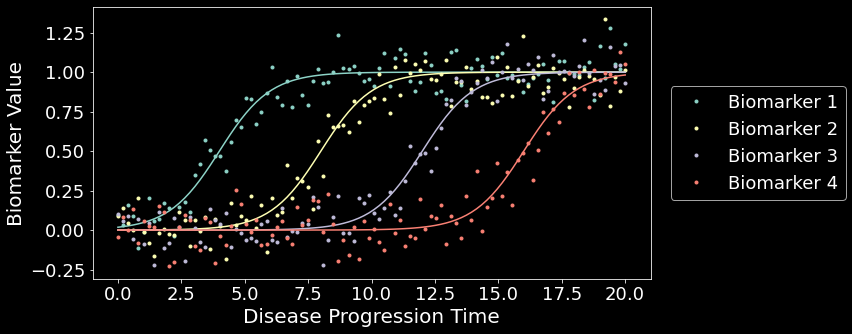

In [2]:
num_features = 4   # number of events/features
num_patients = 100 # number of patients
disease_duration = 20 # Number of years 

noise_scale = 0.1

# Define the disease progression timeline: from 0 (right at onset of disease)
# to 20 (20 years past the onset of disease)
# We will be generating subjects equally spaced along this disease progression timeline
disease_time = np.linspace(0, disease_duration, num_patients)

# Helpful function to geneate sigmoid biomarker tracjectories along the disease time
sigmoid = lambda t, a=1, b=-10 : 1/(1 + np.exp(-a*(t-b)))

X_patients = np.empty(shape=(num_patients,num_features))

# If using dark background, then keep the next line in, otherwise comment it out.
plt.style.use('dark_background')

# Get the colors of the plot so points and lines can be the same. 
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# List of dictionaries for key plotting information of each biomarker
feature_info = [
    { 'label': 'Biomarker 1', 'gradient': 1, 'onset': 4, 'color': colors[0]},
    { 'label': 'Biomarker 2', 'gradient': 1, 'onset': 8, 'color': colors[1]},
    { 'label': 'Biomarker 3', 'gradient': 1, 'onset': 12, 'color': colors[2]},
    { 'label': 'Biomarker 4', 'gradient': 1, 'onset': 16, 'color': colors[3]}
]

fig,ax = plt.subplots(figsize=(10,5))
k=0
for feature in feature_info:
    # print('a = %i, b = %i' % (a,b))
    x = sigmoid(t=disease_time,a=feature['gradient'],b=feature['onset'])
    #print(x)
    ax.plot(disease_time, x, color = feature['color'])
    y = x + np.random.normal(0, noise_scale, x.size)
    X_patients[:,k] = y
    ax.plot(disease_time, y,'.',label=feature['label'], color = feature['color'])
    k = k + 1

ax.set_xlabel("Disease Progression Time",fontsize=20) 
ax.set_ylabel("Biomarker Value",fontsize=20)
ax.legend(bbox_to_anchor=(1.02, 0.5),loc="center left")


The sigmoid function ensures that all of these features turn abnormal at different times $feature['onset']$ so that more individuals have biomarker 1 turning abnormal then 2,3,4.

### Control data
We also need to simulate some controls. For these simulated subjects, we will assume that none will have abnormal values, just some random noise around zero. We will store this matrix of observations in `X_controls`

In [3]:
#* Sample some controls
X_controls = np.empty(shape=X_patients.shape)
for k in range(num_features):
    X_controls[:,k] = np.random.normal(0, 0.05, (X_controls.shape[0],))

## Review the simulated data

### Visual inspection of feature distributions

The first question we should ask when thinking about whether to include a feature in the Event Based Model is "does the feature relate to the disease process?" There is no sense in putting a feature in the EBM if there is no difference in feature's value between patients and controls. The first step is to just *look at the data* by visually checking the feature's distribution in our patient group and control group to make sure there is some evidence of spearation between groups. In the plots below, you can see that for each biomarker the controls stay densely packed around the zero value while the patients have a larger spread. The spread is larger in the earlier biomarkers where less individuals remain within normal levels. 

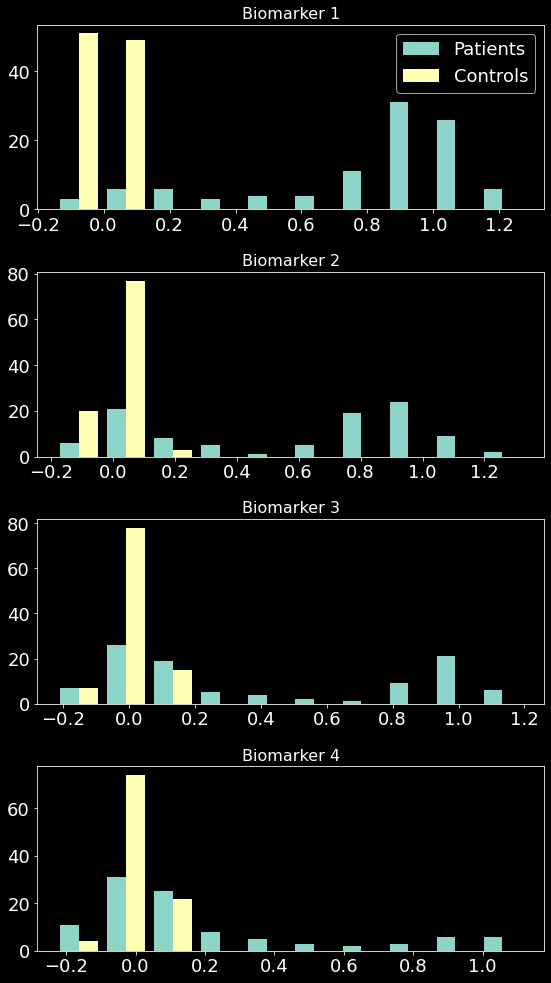

In [4]:
#* 1. Histograms
fig,ax = plt.subplots(num_features,1,figsize=(8,14))
for k in range(num_features):
    ax[k].hist([ X_patients[:,k],X_controls[:,k]],label=['Patients','Controls'])
    ax[k].set_title('Biomarker %i' % (k+1),fontsize=16)
ax[0].legend()
fig.tight_layout()

### Basic statistical tests

We can more formally assess a feature's ability to discriminate between patients and controls using statistical tests. Here we will use non-parametric tests, which make no assumptions about the underlying distribution of the features, where the null hypothesis is that there are no "differences" between groups. If the p-value of test is sufficiently low, that provides us significant evidence that the null hypothesis can be rejected and it would suggest the presence of a "disease signal" (patient measurements are "different" to controls measurements) in a biomarker and thus this feature might have potential as a feature in the EBM.

Details about the statistical test used below:
- Mann-Whitney U test (quoting Wikipedia):<br/>
> a nonparametric test of the null hypothesis that, for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X.
- Effect size: (difference in medians) / ("width" of controls distribution)



In [5]:
#* 2. Basic statistics
# I use a nonparametric test because it works regardless of the data distributions 
# (some tests assume some level of Gaussianity)
from scipy import stats
print('Mann Whitney U test')

for k in range(num_features):
    x_c = X_controls[:,k]
    x_p = X_patients[:,k]
    effect_size = np.absolute(np.median(x_p)-np.median(x_c))/stats.median_abs_deviation(x_c)
    u,p = stats.mannwhitneyu(x_c,x_p)
    print('Biomarker %i\n - effect size = %.3g\n - u = %i, p = %.2g' % (k+1,effect_size,u,p))

Mann Whitney U test
Biomarker 1
 - effect size = 27.1
 - u = 272, p = 3.6e-31
Biomarker 2
 - effect size = 20.6
 - u = 1304, p = 8.6e-20
Biomarker 3
 - effect size = 4.52
 - u = 2327, p = 3.3e-11
Biomarker 4
 - effect size = 1.85
 - u = 3224, p = 7.2e-06


All four statistical tests show substantial evidence of a difference between patients and controls, so they can all be included in the EBM. As expected, the biomarkers that become abnormal earliest in the disease process (1 and 2) have more abnormal values and thus the effect size is the largest (and would be expected the p-value is the smallest) in these biomarkers. 

## Prepare data for fitting
Now that we have determined which features are appropriate for the model, we need to organise the data in a structure that is ready for use in the EBM package. This includes combining all of the patient group and controls into one matrix. We need to add a *label* to tell the EBM which individuals are patients and which individuals are controls. These are stored in the variables `y_patients` and `y_controls`. `X_combined` and `Y_combined` hold these two matrices stacked vertically into one longer matrix, with the patients in the first 100 rows and the controls in the next 100 rows. 

In [6]:
#* Setup data for fitting
y_patients = np.ones(shape=(X_patients.shape[0],1))
y_controls = np.zeros(shape=(X_controls.shape[0],1))

X_combined = np.concatenate((X_patients,X_controls),axis=0)
Y_combined = np.concatenate((y_patients,y_controls),axis=0)
# Make sure that these labels are stored as integer format.
Y_combined = Y_combined.flatten().astype(int)

## Fit mixture models

We now need to map each of the biomarker values to a corresponding probability that the "event" has occurred, here denoted as `p(event)`, which represents how abnormal the biomarker value is. A key point here is that the EBM is a probablistic framework. There is no magic cutpoint where individuals instantly turn from normal to abnormal, but rather the probability that the measured biomarker is abnormal,  allowing for patients to be at different stages of cumulative abnormality.

Typical group-level analyses simply compare measurements from patients with controls, e.g., looking for statistical "differences" in the mean values. The mixture model allows for patients to have both abnormal observations that deviate from controls (these are early disease events), and normal observations (these will be later disease events that have not yet occurred in these patients.)

The first step is to import all the eleements of the kde_ebm package that are needed. 

In [7]:
from kde_ebm.mixture_model import fit_all_kde_models

from kde_ebm.plotting import mixture_model_grid, mcmc_uncert_mat, mcmc_trace, stage_histogram

from kde_ebm.mcmc import mcmc, parallel_bootstrap, bootstrap_ebm, bootstrap_ebm_fixedMM, bootstrap_ebm_return_mixtures


For ease of visualisation, we are creating a few helpful labels for the biomarkers

In [8]:
#* Label the biomarkers/events
event_labels = ['Early','Early-ish','Late-ish','Late']
#* Direction of progression (1 = biomarker increases in patients; -1 = biomarker decreases in patients)
#  This is a feature of the KDE EBM software.
event_disease_direction_dict = {'Early':1,'Early-ish':1,'Late-ish':1,'Late':1}
event_disease_direction = [event_disease_direction_dict[f] for f in event_labels]

Now we can fit the mixture models for each of these biomarkers. In some of the original papers this was done with a Gaussian mixture model, where the underlying distribution of both patients and controls were assumed to have Gaussian distributions. The KDE does not make that assumption and thus can handle data with different distributions.

In [9]:
kde_mixtures = fit_all_kde_models(
    X_combined, Y_combined,
    implement_fixed_controls = True,
    patholog_dirn_array      = event_disease_direction
)

The next command allows us to view the mixture models that were fit to our data. 

(<Figure size 864x864 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'Early'}>,
         <AxesSubplot:title={'center':'Early-ish'}>],
        [<AxesSubplot:title={'center':'Late-ish'}>,
         <AxesSubplot:title={'center':'Late'}>]], dtype=object))

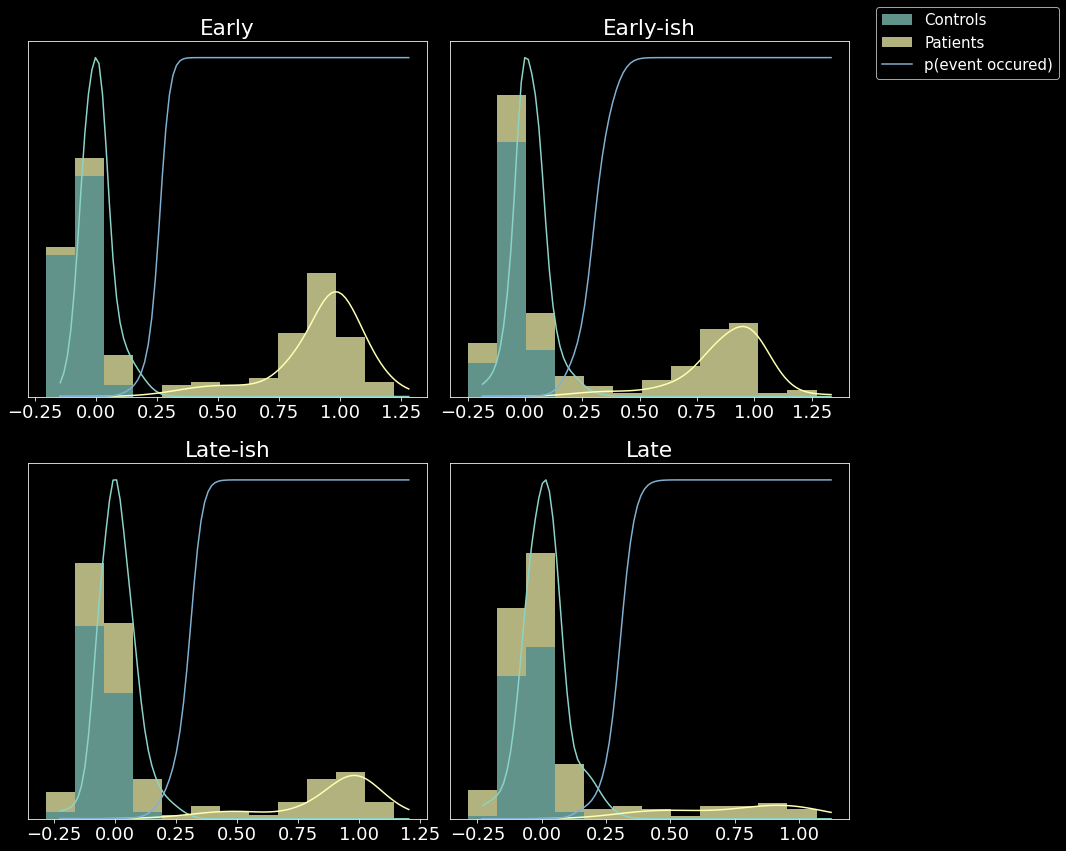

In [10]:
#* View the mixture models
mixture_model_grid(
    X_combined,Y_combined,
    kde_mixtures,
    score_names=event_labels,
    class_names=['Controls','Patients']
)

Notice that despite these events all having different distributions, since they become abnormal at different points of the disease process, the plot of $p(event)$ looks roughly the same for each biomarker, turning abnormal at roughly the same levels (0.25 to 0.50), as we have defined the range of normal/abnormal on similar scales. It is just the number of individuals who will have a value classified as abnormal will be different for each biomarker. 

## Sequencing using MCMC: Markov Chain Monte Carlo

We want to extract the model posterior, which will provide the point estimate of the ideal ordering of events. Ideally, we could calculate the likelihood of every single possible ordering combination and the ordering with the maximum likelihood would be our result. However for $N$ features, this results in $N!$ possible orderings. For our case of four orderings, this would be feasible as it results in $4!$ or 24 possible orderings. However as the number of events included increases, the number of possible orderings explodes. For example, doubling the number of events in the model to eight, results in 40,320 possible orderings. This is where the Markov Chain Monte Carlo method comes into play, it is a standard method for approximating a model posterior when exact inference is intractable.

With MCMC, we generate _random samples from the posterior_ (the full set of possible sequences), and keep only those sequences that increase the likelihood (ideally towards the maximum).

In practice, the posterior won't be a convex function, i.e., one having a single easy-to-find maximum. The posterior could consist of multiple local maxima at different locations in parameter space. To avoid getting "stuck" in a local maximum, we follow good machine learning practice when searching parameter space to sample from the posterior: multiple random initialisations of the sampling, greedy initialisation, and MCMC sampling.

Details of the bespoke MCMC algorithm used here are in the original EBM paper: [Fonteijn _et al._, NeuroImage (2012)](https://doi.org/10.1016/j.neuroimage.2012.01.062).


100%|██████████| 1000/1000 [00:00<00:00, 9401.40it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8998.35it/s]


ML order   : Early, Early-ish, Late-ish, Late


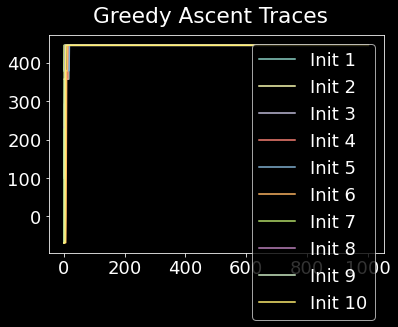

In [11]:
#* MCMC sequencing
mcmc_samples = mcmc(X_combined, kde_mixtures)
#* Maximum Likelihood sequence over all samples
seq_ml = mcmc_samples[0].ordering
# print('ML sequence: {0}'.format(seq_ml))
print('ML order   : %s' % ', '.join([event_labels[k] for k in seq_ml]))
      

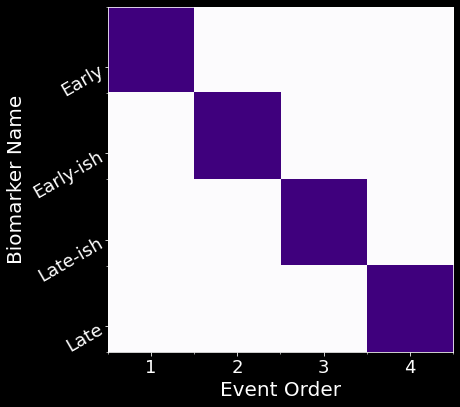

In [12]:
# View the ML posterior
f,a = mcmc_uncert_mat(mcmc_samples, ml_order=None, score_names=event_labels)

The ordering is as we would expect it to be, the Early one is first, followed by Early-ish, Late-ish, and Late. This corresponds with how these biomarkers were set to transition from normal to abnormal at 4,8,12,and 16 years respectively. 

We are going to use the results from the MCMC sampling later, so we are going to save them in a dictionary.

In [13]:
# Save in a dict()
ebm_results = {"mixtures": kde_mixtures, "mcmc_samples": mcmc_samples, "sequence_ml": seq_ml}

### Example of how to tweak the output positional variance diagram

In the file kde_util.py, there are some convenience functions defined to plot some of the variance diagrams. If interested in what they do, please look at them. If you want to use them in your notebook, please include the from .kde_utils import line.

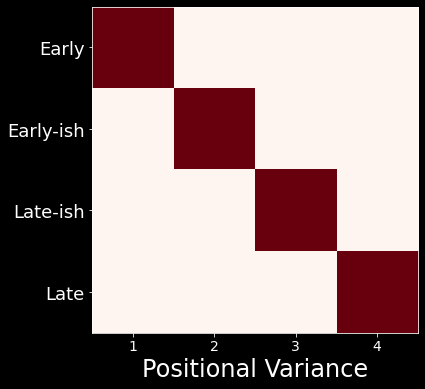

In [14]:
import kde_utils 
nom = 'tute'
#* Plot EBM (PVD)
pvd_ml, seq_ml = kde_utils.extract_pvd(ml_order=seq_ml,samples=mcmc_samples)
reorder_ml = np.argsort(seq_ml)
pvd_ml_ = pvd_ml[:][reorder_ml]

fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
labels = event_labels
labels_ = [labels[i].replace('TOTAL','').replace('TOT','').replace('-detrended','') for i in seq_ml]
ax.imshow(pvd_ml_[:][seq_ml], interpolation='nearest', cmap='Reds')

n_biomarkers = pvd_ml.shape[0]
stp = 1
fs = 14
tick_marks_x = np.arange(0,n_biomarkers,stp)
x_labs = range(1, n_biomarkers+1,stp)
ax.set_xticks(tick_marks_x)
ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax.set_yticks(tick_marks_y+0.0)
ax.tick_params(axis='y',color='w')
labels_trimmed = [x[2:].replace('_', ' ') if x.startswith('p_') else x.replace('_', ' ') for x in labels_]
ax.set_yticklabels(labels_trimmed,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=18)
# ax.set_ylabel('Instrument', fontsize=28)
ax.set_xlabel('Positional Variance', fontsize=24)
ax.grid(False)

kde_utils.save_plot(fig, nom+"-PVD_ML")

## Patient staging utility

Concept: align individuals to the model

Method (see [Young et al, Brain 2014](https://doi.org/10.1093/brain/awu176)): compare data from each individual (patients/controls/at-risk) with the model and calculate a `p(event)` vector, then assign the most likely stage according to the accumulation of disease events

In [15]:
#* Staging
#* Maximum-likelihood model stage: could include longitudinal data, including followups not used to train the EBM
prob_mat_ml, stages_long_ml, stage_likelihoods_long_ml, stages_long_ml_expected = kde_utils.ebm_staging(
    x=X_combined,
    mixtures=kde_mixtures,
    samples=mcmc_samples
)
stages_long = stages_long_ml

### Plot a staging histogram

Number of individuals in each EBM stage

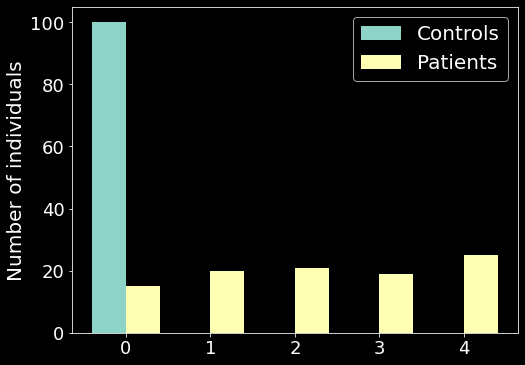

In [16]:
fig, ax = plt.subplots(figsize=(8,6))

ax.hist([ stages_long[Y_combined==0], stages_long[Y_combined==1]],bins=np.arange(-0.5,num_features+1.5,1))
# #* Seaborn version: requires creating a Pandas DataFrame and adding data/etc.
# ax = sns.histplot(
#     data = df_staging,
#     x    = stage_column,
#     hue  = "Status",
#     ax   = ax
#     discrete  = True,
#     multiple  = "dodge",
#     log_scale = (False, True),
#     palette   = status_palette,
# )
ax.set_ylabel('Number of individuals',fontsize=20)
ax.legend(['Controls','Patients'],fontsize=20)

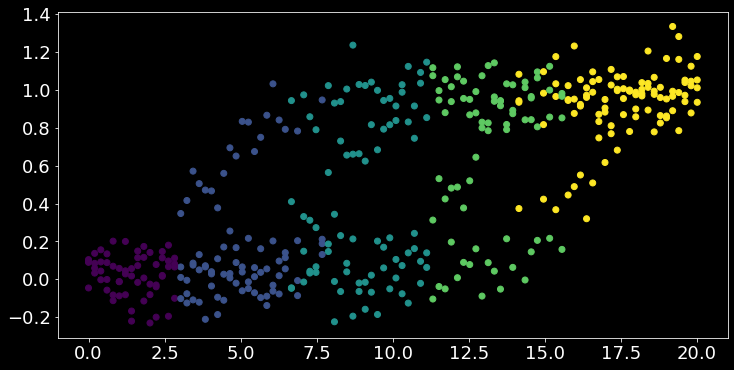

In [17]:
#* Plot the original data, coloured by stage
fig,ax = plt.subplots(figsize=(12,6))

for k in range(num_features):
    plt.scatter(disease_time,X_combined[Y_combined==1,k],c=stages_long[Y_combined==1],cmap='viridis',label='')
    #plt.plot
# ax.legend(['Stage %i' % k for k in range(N)],loc='center right',bbox_to_anchor=[1.5,0.5])


<hr/>
<hr/>

## Bonus: Cross-validation

Generalizability/robustness of a model can be quantified by **testing** the model on independent data, i.e., data not included when training the model.

Cross-validation does this by splitting the available data into train/test sets.

### k-fold cross-validation

Splitting a dataset into `k` "folds" enables calculation of model performance statistics (e.g., mean, standard deviation) over `k` test sets, using the other `k-1` folds to train the model each time.

It is common to use `k=10`, which amounts to using 90% of your data to train and 10% to test.

This process can be repeated multiple times using different random partitions (splits) into folds.


![image_kfold_cv](https://upload.wikimedia.org/wikipedia/commons/b/b5/K-fold_cross_validation_EN.svg)

By Gufosowa - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=82298768


100%|██████████| 1000/1000 [00:00<00:00, 9482.08it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8070.63it/s]


Repeated CV fold 1 of 50


100%|██████████| 1000/1000 [00:00<00:00, 9613.44it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8086.26it/s]


Repeated CV fold 2 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8333.26it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8896.61it/s]


Repeated CV fold 3 of 50


100%|██████████| 1000/1000 [00:00<00:00, 9332.97it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 9036.66it/s]


Repeated CV fold 4 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8451.52it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8705.39it/s]


Repeated CV fold 5 of 50


100%|██████████| 1000/1000 [00:00<00:00, 7320.48it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8204.72it/s]


Repeated CV fold 6 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8532.00it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8601.49it/s]


Repeated CV fold 7 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8786.29it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8841.92it/s]


Repeated CV fold 8 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8366.52it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8894.00it/s]


Repeated CV fold 9 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8084.92it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8898.00it/s]


Repeated CV fold 10 of 50


100%|██████████| 1000/1000 [00:00<00:00, 7620.02it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 7821.73it/s]


Repeated CV fold 11 of 50


100%|██████████| 1000/1000 [00:00<00:00, 7096.54it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 7743.16it/s]


Repeated CV fold 12 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8477.30it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8117.22it/s]


Repeated CV fold 13 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8684.00it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8047.30it/s]


Repeated CV fold 14 of 50


100%|██████████| 1000/1000 [00:00<00:00, 7900.40it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8800.07it/s]


Repeated CV fold 15 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8555.86it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8019.99it/s]


Repeated CV fold 16 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8570.39it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8544.58it/s]


Repeated CV fold 17 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8476.82it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8596.85it/s]


Repeated CV fold 18 of 50


100%|██████████| 1000/1000 [00:00<00:00, 9166.15it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8162.81it/s]


Repeated CV fold 19 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8413.48it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8702.08it/s]


Repeated CV fold 20 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8602.82it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/plotting/plotting.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8924.83it/s]


Repeated CV fold 21 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8241.43it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 7357.28it/s]


Repeated CV fold 22 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8558.98it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 5865.64it/s]


Repeated CV fold 23 of 50


100%|██████████| 1000/1000 [00:00<00:00, 7343.50it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8419.63it/s]


Repeated CV fold 24 of 50


100%|██████████| 1000/1000 [00:00<00:00, 9125.43it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8372.51it/s]


Repeated CV fold 25 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8862.60it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8034.64it/s]


Repeated CV fold 26 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8852.70it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8409.07it/s]


Repeated CV fold 27 of 50


100%|██████████| 1000/1000 [00:00<00:00, 9071.86it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8589.65it/s]


Repeated CV fold 28 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8698.43it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8791.19it/s]


Repeated CV fold 29 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8702.15it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8691.69it/s]


Repeated CV fold 30 of 50


100%|██████████| 1000/1000 [00:00<00:00, 7743.05it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8294.20it/s]


Repeated CV fold 31 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8855.43it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8859.52it/s]


Repeated CV fold 32 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8013.97it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8121.78it/s]


Repeated CV fold 33 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8926.20it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8868.23it/s]


Repeated CV fold 34 of 50


100%|██████████| 1000/1000 [00:00<00:00, 9159.95it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8910.80it/s]


Repeated CV fold 35 of 50


100%|██████████| 1000/1000 [00:00<00:00, 7888.69it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8769.60it/s]


Repeated CV fold 36 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8669.03it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8335.16it/s]


Repeated CV fold 37 of 50


100%|██████████| 1000/1000 [00:00<00:00, 6410.50it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 7383.02it/s]


Repeated CV fold 38 of 50


100%|██████████| 1000/1000 [00:00<00:00, 9303.10it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8458.90it/s]


Repeated CV fold 39 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8444.82it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8752.85it/s]


Repeated CV fold 40 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8062.03it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 7508.63it/s]


Repeated CV fold 41 of 50


100%|██████████| 1000/1000 [00:00<00:00, 7559.09it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 7729.00it/s]


Repeated CV fold 42 of 50


100%|██████████| 1000/1000 [00:00<00:00, 7747.86it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 7737.36it/s]


Repeated CV fold 43 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8361.98it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 7904.51it/s]


Repeated CV fold 44 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8290.83it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8538.99it/s]


Repeated CV fold 45 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8350.05it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8527.80it/s]


Repeated CV fold 46 of 50


100%|██████████| 1000/1000 [00:00<00:00, 7986.66it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 7838.85it/s]


Repeated CV fold 47 of 50


100%|██████████| 1000/1000 [00:00<00:00, 7704.52it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8382.20it/s]


Repeated CV fold 48 of 50


100%|██████████| 1000/1000 [00:00<00:00, 7927.20it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8694.62it/s]


Repeated CV fold 49 of 50


100%|██████████| 1000/1000 [00:00<00:00, 8474.71it/s]
/Users/davecash/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 10000/10000 [00:01<00:00, 8384.18it/s]


Repeated CV fold 50 of 50


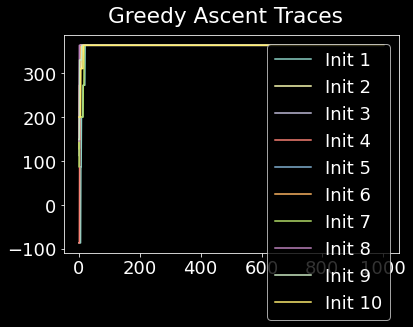

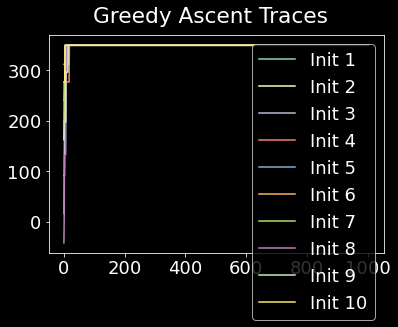

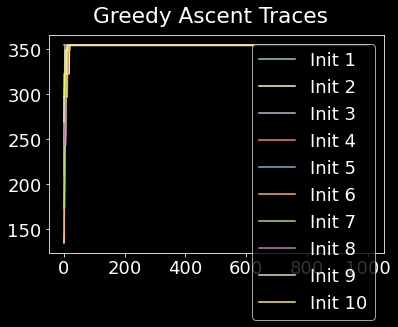

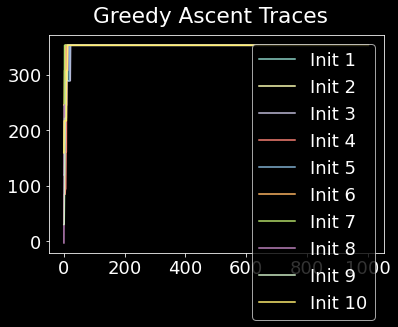

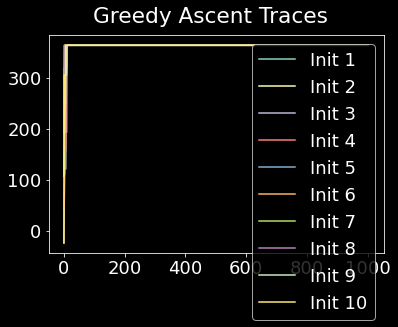

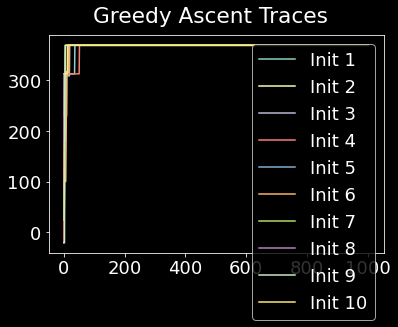

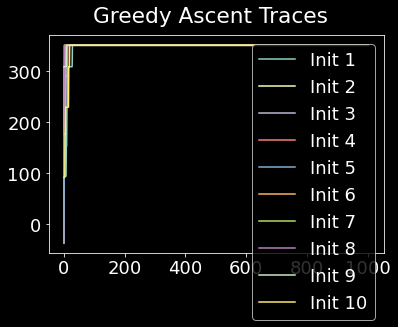

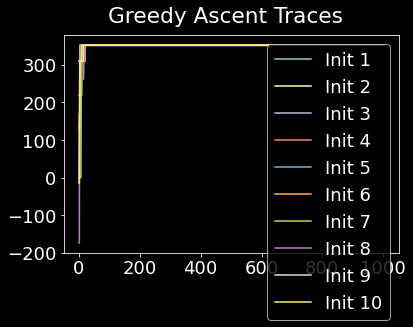

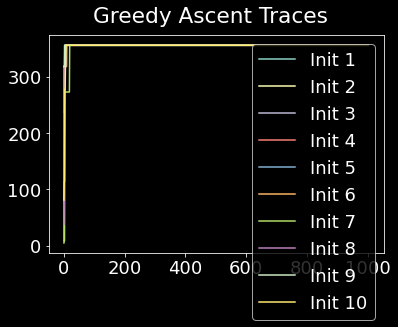

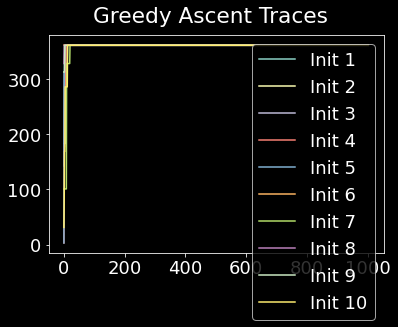

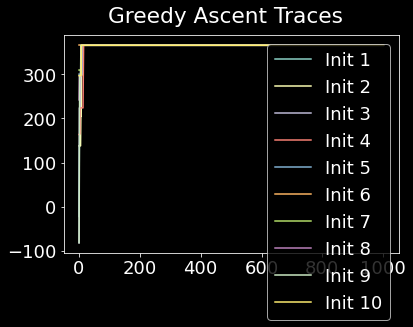

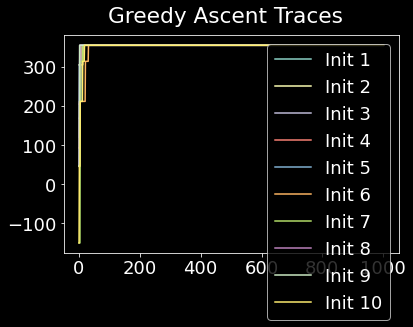

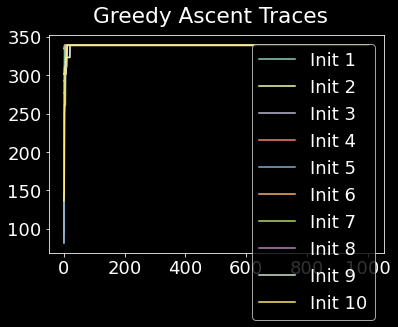

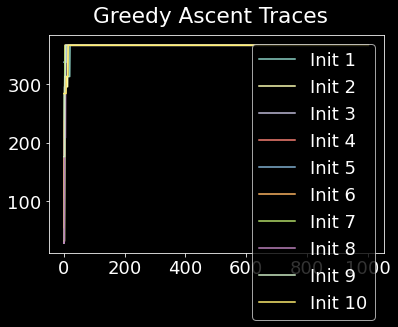

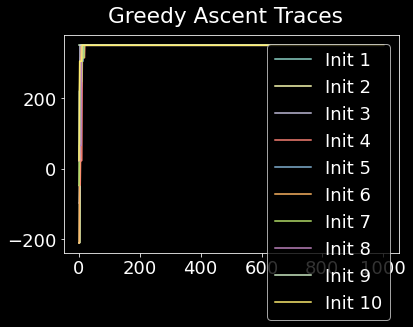

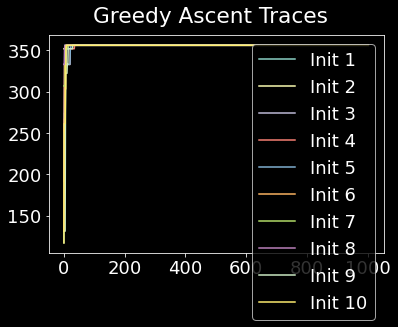

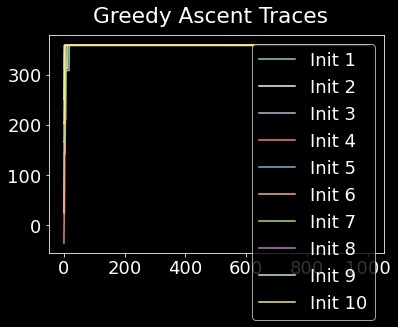

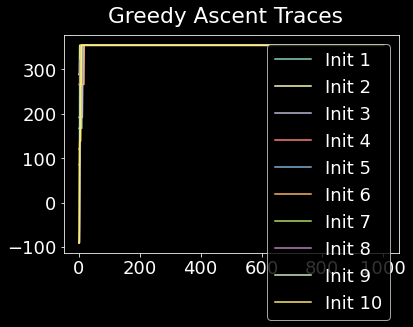

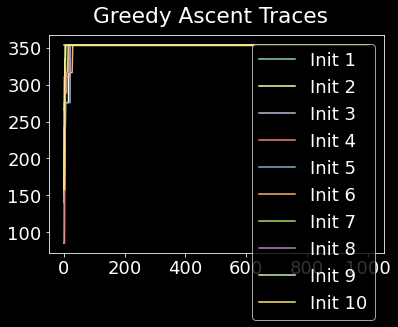

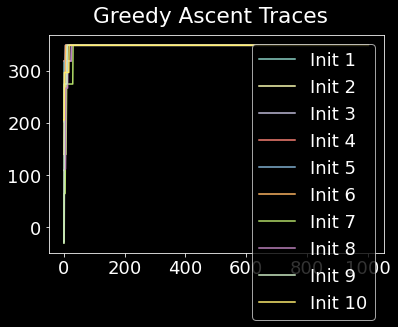

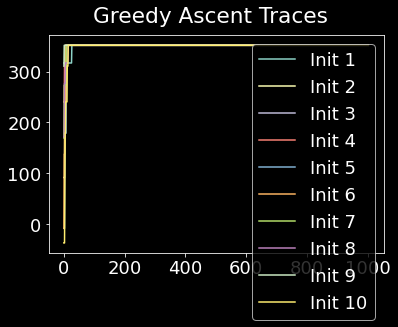

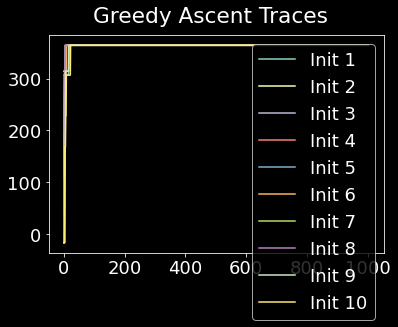

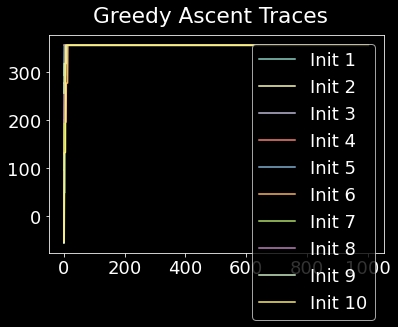

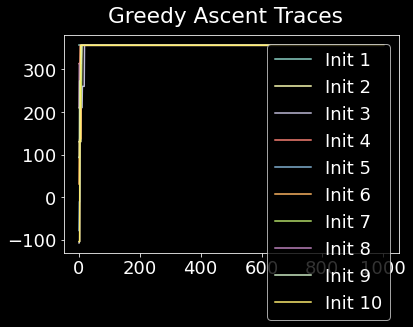

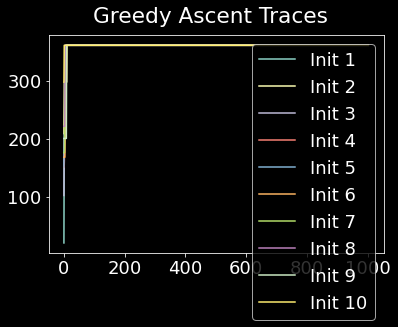

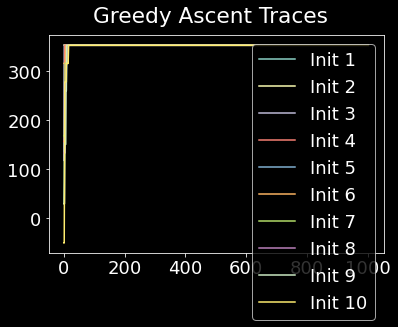

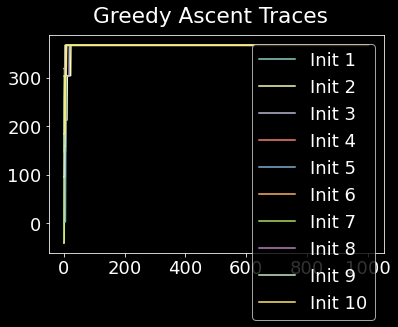

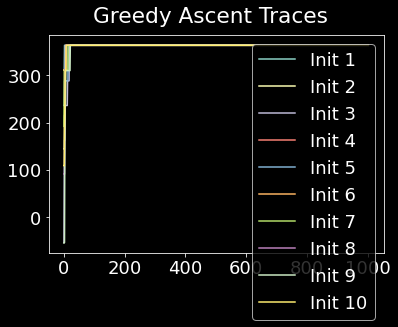

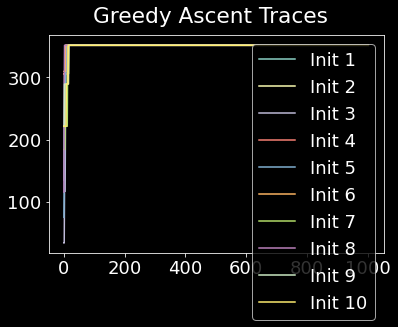

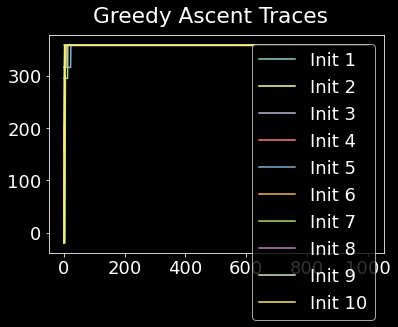

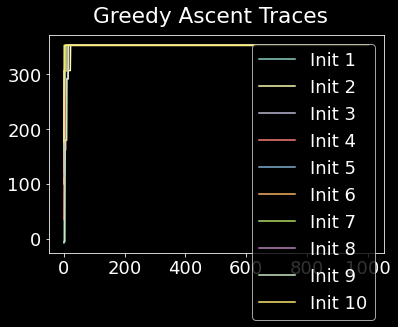

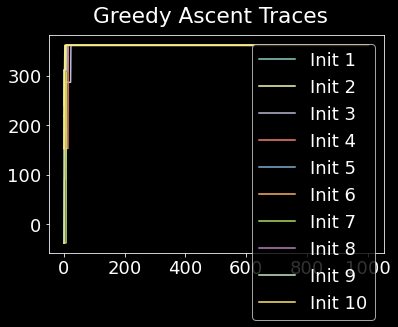

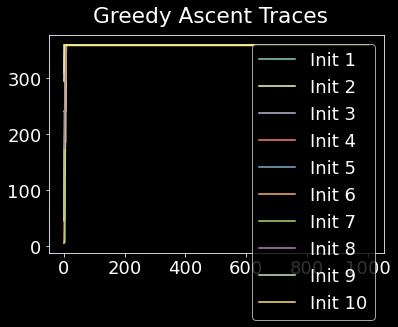

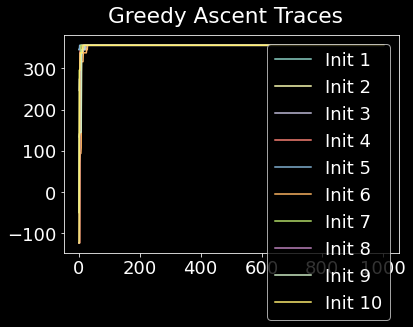

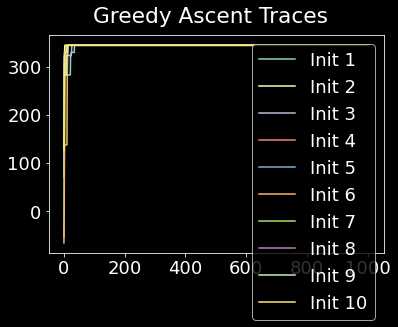

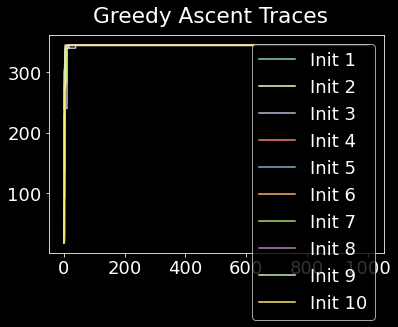

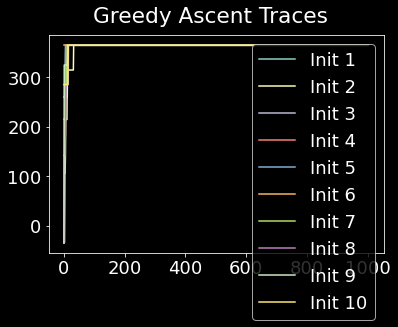

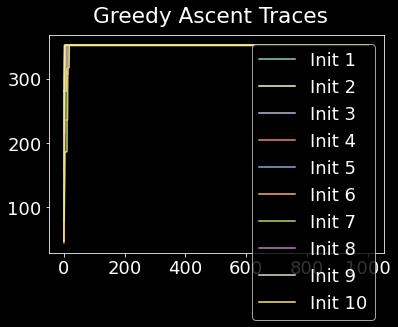

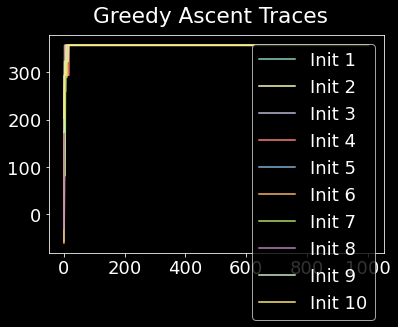

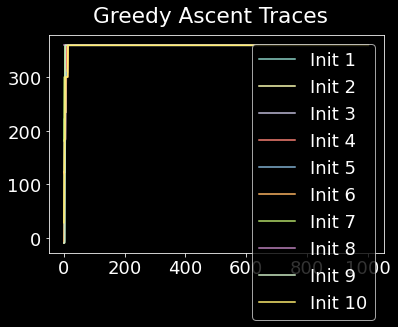

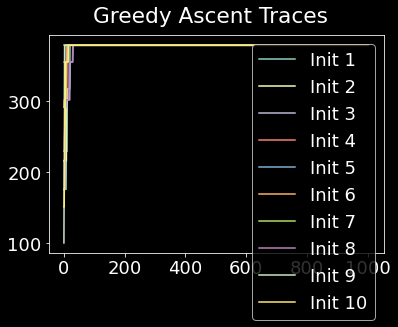

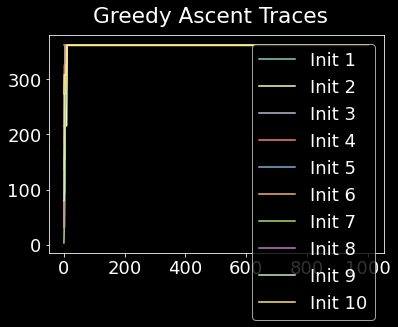

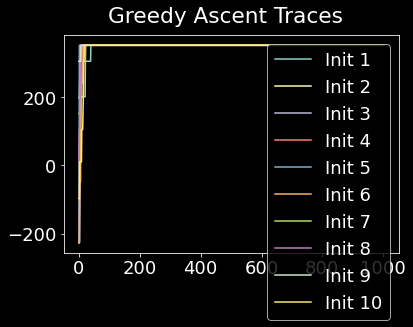

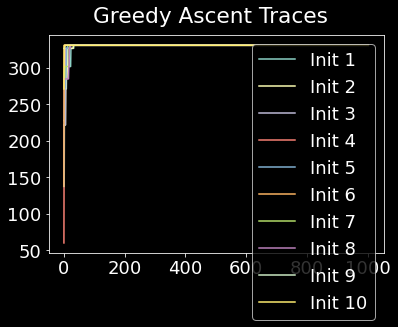

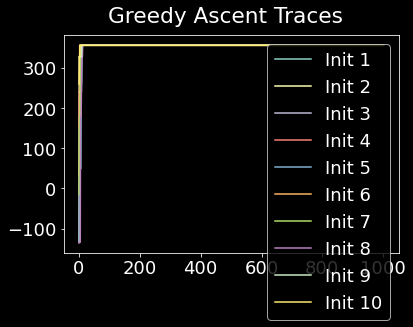

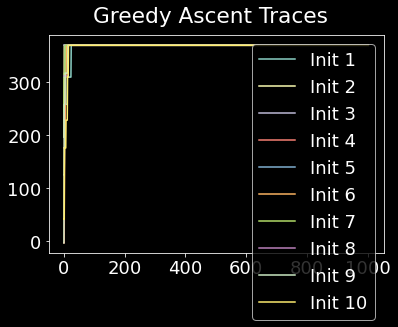

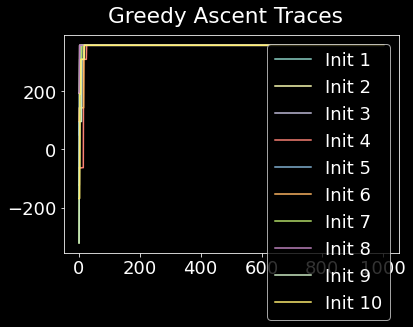

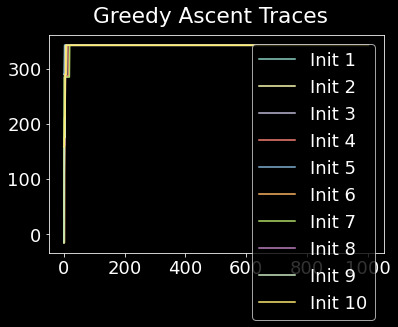

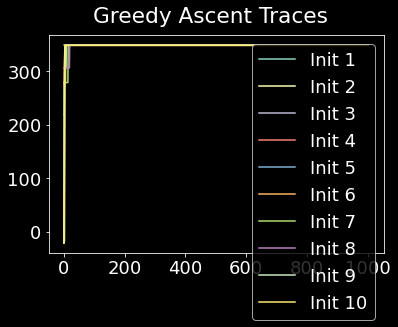

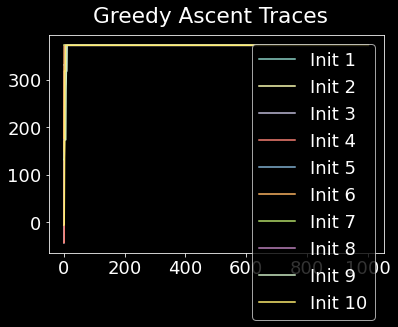

In [18]:
from sklearn.model_selection import RepeatedStratifiedKFold
#* RCV1: Repeated, stratified 5-fold CV - uses ML stage as ground truth for test folds
k_folds = 5
n_repeats = 10

repeated_cvfolds = RepeatedStratifiedKFold(n_splits=k_folds, n_repeats=n_repeats) #, random_state=36851234)
if 'ebm_results' in locals():
    check = True
else:
    check = False


if check:
    if "mixtures_rcv" in ebm_results:
        kde_mixtures_rcv = ebm_results["mixtures_rcv"]
        mcmc_samples_rcv = ebm_results["mcmc_samples_rcv"]
        seqs_rcv = ebm_results["sequences_rcv"]
        staging_errors_rcv = ebm_results["staging_errors_rcv"]
        runit = False
    else:
        runit = True
else:
    runit = True

if runit:
    kde_mixtures_rcv, mcmc_samples_rcv, seqs_rcv, staging_errors_rcv = kde_utils.ebm_2_repeatedcv(
        x=X_combined,
        y=Y_combined,
        events=event_labels,
        rcv_folds=repeated_cvfolds,
        implement_fixed_controls=True,
        patholog_dirn_array=event_disease_direction,
        model_stage=stages_long
    )
    #* Save
    ebm_results["mixtures_rcv"] = kde_mixtures_rcv
    ebm_results["mcmc_samples_rcv"] = mcmc_samples_rcv
    ebm_results["sequences_rcv"] = seqs_rcv
    ebm_results["staging_errors_rcv"] = staging_errors_rcv
    # pickle_file = open(pickle_path,'wb')
    # pickle_output = pickle.dump(ebm_results, pickle_file)
    # pickle_file.close()

Text(0.5, 0, 'Sequence')

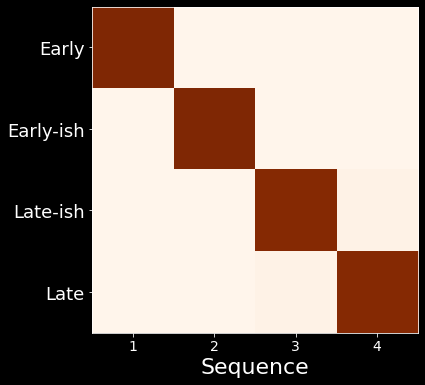

In [19]:
#* Plot EBM (PVD)
pvd_rcv, seq_rcv = kde_utils.extract_pvd(ml_order=seqs_rcv,samples=mcmc_samples_rcv)
reorder_rcv = np.argsort(seq_rcv)
pvd_rcv_ = pvd_rcv[:][reorder_rcv]

fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
labels = event_labels
labels_ = [labels[i].replace('TOTAL','').replace('TOT','').replace('-detrended','') for i in seq_rcv]
ax.imshow(pvd_rcv_[:][seq_rcv], interpolation='nearest', cmap='Oranges')
# ax.set_title('Cross-Validation',fontsize=24)

n_biomarkers = pvd_rcv.shape[0]
stp = 1
fs = 14
tick_marks_x = np.arange(0,n_biomarkers,stp)
x_labs = range(1, n_biomarkers+1,stp)
ax.set_xticks(tick_marks_x)
ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax.set_yticks(tick_marks_y+0)
ax.tick_params(axis='y',color='w')
labels_trimmed = [x[2:].replace('_', ' ') if x.startswith('p_') else x.replace('_', ' ') for x in labels_]
ax.set_yticklabels(labels_trimmed,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=18)
# ax.set_ylabel('Instrument', fontsize=28)
ax.set_xlabel('Sequence', fontsize=22)

If running on real data, you might consider staging your participant data using the cross-validated model (above uses the maximum-likleihood model which can be overconfident). Then you might re-run the CV.